In [2]:
from query_strategies import UncertaintySampling, RandomSampling, ClusterMarginSampling
from query_strategies import DynamicEnsembleActiveLearning, ActiveLearningByLearning
from query_strategies.core import SVM, Dataset
from sklearn.utils import shuffle
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [3]:
scores = np.zeros((5,97))
X, y = load_iris(return_X_y=True)
y = y.tolist()

for i in range(200):
    while True:
        X, y= shuffle(X,y)
        if len(set(y[:3]))>2:
            break
    y_train = y[:3] +97*[None]
    dataset_train = Dataset(X[:100], y_train)
    dataset_test = Dataset(X[100:], y[100:])
    dataset_train_2 = Dataset(X[:100], y_train)
    d_train_1 = Dataset(X[:100], y_train)
    d_train_2 = Dataset(X[:100], y_train)
    d_train_3 = Dataset(X[:100], y_train)


    query_strategy = [UncertaintySampling(dataset_train, model = SVM(gamma = 15, kernel = 'linear', random_state = 1)),
                     ClusterMarginSampling(dataset_train,space='full')]
    query_strategy_2 = [UncertaintySampling(dataset_train_2, model = SVM(gamma = 15, kernel = 'linear', random_state = 1)), 
                        ClusterMarginSampling(dataset_train_2, space= 'full'), RandomSampling(dataset_train_2)]
    albl = ActiveLearningByLearning(dataset_train,
                                        query_strategy = query_strategy,
                                        model = SVM(kernel = 'linear', random_state = 1, gamma = 15),
                                        T=97)
    deal = DynamicEnsembleActiveLearning(dataset_train_2,
                                        query_strategy = query_strategy_2,
                                        model = SVM(kernel = 'linear', random_state = 1, gamma = 15),
                                        T=97,delta_T = 10)

    us = UncertaintySampling(d_train_1, model = SVM(gamma=15, kernel ='linear', random_state = 1))
    rs = RandomSampling(d_train_2)
    rs_clf = SVM(random_state =1, gamma=15, kernel='linear')
    cs = ClusterMarginSampling(d_train_3, space = 'full')
    for j in range(97):
        rs_clf.train(d_train_2)
        scores[3,j] += rs_clf.score(dataset_test)
        rs_clf.train(d_train_3)
        scores[4,j] += rs_clf.score(dataset_test)
        
        idx = albl.make_query()
        dataset_train.update(idx, y[idx])
        idx = deal.make_query()
        dataset_train_2.update(idx, y[idx])
        idx = us.make_query()[0]
        d_train_1.update(idx, y[idx])
        idx = rs.make_query()[0]
        d_train_2.update(idx, y[idx])
        idx = cs.make_query()[0]
        d_train_3.update(idx, y[idx])
        
        scores[0,j] += albl.model.score(dataset_test)
        scores[1,j] += deal.model.score(dataset_test)
        scores[2,j] += us.model.score(dataset_test)
        
        
        

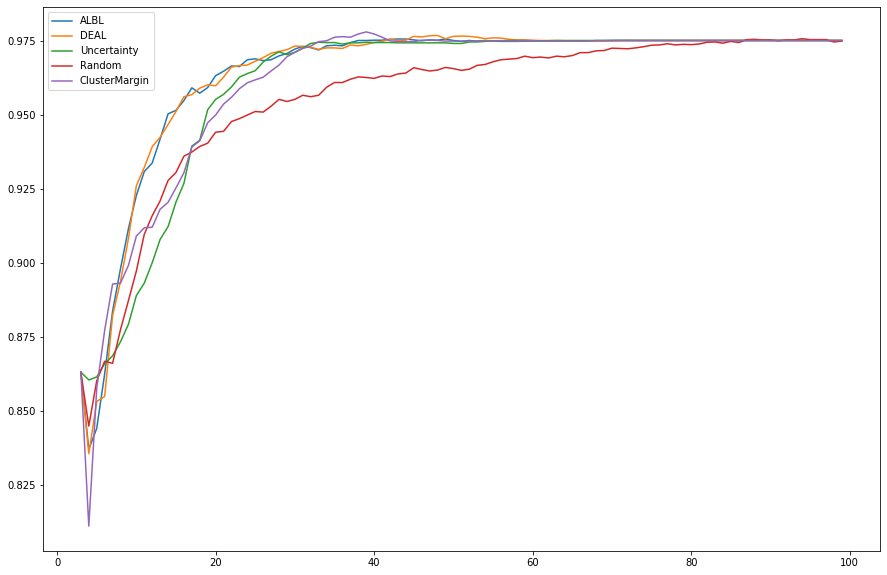

In [10]:
#scores = scores/200
plt.figure(figsize=(15,10)) 
plt.plot(range(3,100), scores[0,:], label = 'ALBL')
plt.plot(range(3,100), scores[1,:], label = 'DEAL')
plt.plot(range(3,100), scores[2,:], label = 'Uncertainty')
plt.plot(range(3,100), scores[3,:], label = 'Random')
plt.plot(range(3,100), scores[4,:], label = 'ClusterMargin')


plt.legend()